In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-DC4Balance-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Presynoviomics-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20210621-DataSheet-RUN41-human-TCRb.csv"
run = "run41"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run41-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BP-T069A-TuH_S1,ACGTACGT,CASSQLAEETQYFG,360,279,TRBV5-4,"TRBJ2-5,TRBJ2-7",360,1.000000,0.518612,0.546952
1,BP-T069A-TuH_S1,ACGTACGT,CASTRSPGANVLTFG,271,176,TRBV27,TRBJ2-6,270,0.996310,0.390400,0.345030
2,BP-T069A-TuH_S1,ACGTACGT,CASSLTGPPAFFG,246,169,TRBV5-5,TRBJ1-1,242,0.983740,0.354385,0.331308
3,BP-T069A-TuH_S1,ACGTACGT,CSVGTGGTNEKLFFG,186,132,TRBV29-1,TRBJ1-4,371,1.994624,0.267950,0.258773
4,BP-T069A-TuH_S1,ACGTACGT,CSVLPDSTDTQYFG,168,114,TRBV29-1,TRBJ2-3,333,1.982143,0.242019,0.223486


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
657829,Bx1481-ST-T_S229,CASRSLAGDTGELFFG,276,65,275,0.996377,1.990767,1.484018
658374,Bx1481-ST-T_S229,CASSLMGLGDTIYFG,245,70,245,1.000000,1.767167,1.598174
659069,Bx1481-ST-T_S229,CASSYEGRSTGELFFG,122,40,122,1.000000,0.879977,0.913242
658399,Bx1481-ST-T_S229,CASSLPGQRTDTQYFG,104,20,104,1.000000,0.750144,0.456621
657899,Bx1481-ST-T_S229,CASSDSTGGTDTQYFG,95,32,95,1.000000,0.685228,0.730594


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,Constant,HEK_cells,RACE,MID
0,N701_S502,BP-T069A-TuH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,DC4Balance,human,TCRb,P53V01,Pre (aliquot A),yes,no,yes,no,NaN
1,N702_S502,BP-T070B-TuH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,DC4Balance,human,TCRb,P53V01,Pre (aliquot B),yes,no,yes,no,NaN
2,N703_S502,BP-T071C-TuH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,DC4Balance,human,TCRb,P53V01,Pre (aliquot C),yes,no,yes,no,NaN
3,N704_S502,BP-T072D-TuH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,DC4Balance,human,TCRb,P53V01,Pre (aliquot D),yes,no,yes,no,NaN
4,N705_S502,BP-T073A-TuH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,DC4Balance,human,TCRb,P53V01,Post Stim(aliquot A),yes,no,yes,no,NaN


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,BP-T069A-TuH_S1,P53V01
1,BP-T070B-TuH_S2,P53V01
2,BP-T071C-TuH_S3,P53V01
3,BP-T072D-TuH_S4,P53V01
4,BP-T073A-TuH_S5,P53V01


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,Bx1481-ST-T_S229,CASRSLAGDTGELFFG,276,65,275,0.996377,1.990767,1.484018,Bx1481
1,Bx1481-ST-T_S229,CASSLMGLGDTIYFG,245,70,245,1.000000,1.767167,1.598174,Bx1481
2,Bx1481-ST-T_S229,CASSYEGRSTGELFFG,122,40,122,1.000000,0.879977,0.913242,Bx1481
3,Bx1481-ST-T_S229,CASSLPGQRTDTQYFG,104,20,104,1.000000,0.750144,0.456621,Bx1481
4,Bx1481-ST-T_S229,CASSDSTGGTDTQYFG,95,32,95,1.000000,0.685228,0.730594,Bx1481


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                        B13V5           BB3855           BB4064  \
Sample               B13V5-PB-T_S225 BB3855-LN-T_S227 BB4064-LN-T_S226   
cdr3pep                                                                  
CAAAAGLTADRSSYNEQFFG             0.0              0.0              0.0   
CAAAATTSTDTQYFG                  0.0              0.0              2.0   
CAAADDSGANVLTFG                  0.0              0.0              0.0   
CAAAEEGRITDTQYFG                 0.0              0.0              0.0   
CAAAEGEEEKLFFG                   0.0              0.0              0.0   

Patient                        BB4679                            Bx1481  \
Sample               BB4679-LN-T_S228 BB4679-PB-T_S224 Bx1481-ST-T_S229   
cdr3pep                                                                   
CAAAAGLTADRSSYNEQFFG              0.0              0.0              0.0   
CAAAATTSTDTQYFG                   0.0              0.0              0.0   
CAAADDSGANVLTFG                   0.0              0.0              0.0   
CAAAEEGRITDTQYFG                  0.0              0.0              0.0   
CAAAEGEEEKLFFG                    0.0              0.0              0.0   

Patient                        P20V01                                    \
Sample               BP-T103A-TuH_S52 BP-T104B-TuH_S53 BP-T105C-TuH_S54   
cdr3pep                                                                   
CAAAAGLTADRSSYNEQFFG              0.0              0.0              0.0   
CAAAATTSTDTQYFG                   0.0              0.0              0.0   
CAAADDSGANVLTFG                   0.0              0.0              0.0   
CAAAEEGRITDTQYFG                  0.0              0.0              0.0   
CAAAEGEEEKLFFG                    0.0              0.0              0.0   

Patient                                     ...                P53V01  \
Sample               BP-T106D-TuH_S55       ...       BP-T086-TuH_S26   
cdr3pep                                     ...                         
CAAAAGLTADRSSYNEQFFG              0.0       ...                   0.0   
CAAAATTSTDTQYFG                   0.0       ...                   0.0   
CAAADDSGANVLTFG                   0.0       ...                   0.0   
CAAAEEGRITDTQYFG                  0.0       ...                   0.0   
CAAAEGEEEKLFFG                    0.0       ...                   0.0   

Patient                                                               \
Sample               BP-T087-TuH_S27 BP-T088-TuH_S28 BP-T089-TuH_S29   
cdr3pep                                                                
CAAAAGLTADRSSYNEQFFG             0.0             0.0             0.0   
CAAAATTSTDTQYFG                  0.0             0.0             0.0   
CAAADDSGANVLTFG                  0.0             0.0             0.0   
CAAAEEGRITDTQYFG                 0.0             0.0             0.0   
CAAAEGEEEKLFFG                   0.0             0.0             0.0   

Patient                      P53V010                          P53V07  \
Sample               BP-T097-TuH_S50 BP-T098-TuH_S51 BP-T091-TuH_S30   
cdr3pep                                                                
CAAAAGLTADRSSYNEQFFG             0.0             0.0             0.0   
CAAAATTSTDTQYFG                  0.0             0.0             0.0   
CAAADDSGANVLTFG                  0.0             0.0             0.0   
CAAAEEGRITDTQYFG                 0.0             0.0             0.0   
CAAAEGEEEKLFFG                   0.0             0.0             0.0   

Patient                                                               
Sample               BP-T092-TuH_S31 BP-T094-TuH_S32 BP-T095-TuH_S49  
cdr3pep                                                               
CAAAAGLTADRSSYNEQFFG             0.0             0.0             0.0  
CAAAATTSTDTQYFG                  0.0             0.0             0.0  
CAAADDSGANVLTFG                  0.0             0.0             0.0  
CAAAEEGRITDTQYFG                 0.0    

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                            B13V5           BB3855           BB4064  \
Sample                   B13V5-PB-T_S225 BB3855-LN-T_S227 BB4064-LN-T_S226   
Patient Sample                                                               
B13V5   B13V5-PB-T_S225         1.000000         0.008793         0.009309   
BB3855  BB3855-LN-T_S227        0.008793         1.000000         0.011819   
BB4064  BB4064-LN-T_S226        0.009309         0.011819         1.000000   
BB4679  BB4679-LN-T_S228        0.008824         0.012447         0.010839   
        BB4679-PB-T_S224        0.009045         0.012150         0.011782   

Patient                            BB4679                            Bx1481  \
Sample                   BB4679-LN-T_S228 BB4679-PB-T_S224 Bx1481-ST-T_S229   
Patient Sample                                                                
B13V5   B13V5-PB-T_S225          0.008824         0.009045         0.002045   
BB3855  BB3855-LN-T_S227         0.012447         0.012150         0.002474   
BB4064  BB4064-LN-T_S226         0.010839         0.011782         0.001944   
BB4679  BB4679-LN-T_S228         1.000000         0.078716         0.002850   
        BB4679-PB-T_S224         0.078716         1.000000         0.002511   

Patient                            P20V01                                    \
Sample                   BP-T103A-TuH_S52 BP-T104B-TuH_S53 BP-T105C-TuH_S54   
Patient Sample                                                                
B13V5   B13V5-PB-T_S225          0.005749         0.005382         0.004965   
BB3855  BB3855-LN-T_S227         0.006629         0.007343         0.006804   
BB4064  BB4064-LN-T_S226         0.006881         0.007119         0.005905   
BB4679  BB4679-LN-T_S228         0.007477         0.006728         0.006646   
        BB4679-PB-T_S224         0.007395         0.007550         0.006462   

Patient                                         ...                P53V01  \
Sample                   BP-T106D-TuH_S55       ...       BP-T086-TuH_S26   
Patient Sample                                  ...                         
B13V5   B13V5-PB-T_S225          0.005115       ...              0.003845   
BB3855  BB3855-LN-T_S227         0.006497       ...              0.004338   
BB4064  BB4064-LN-T_S226         0.006511       ...              0.003697   
BB4679  BB4679-LN-T_S228         0.006017       ...              0.004590   
        BB4679-PB-T_S224         0.006802       ...              0.005725   

Patient                                                                   \
Sample                   BP-T087-TuH_S27 BP-T088-TuH_S28 BP-T089-TuH_S29   
Patient Sample                                                             
B13V5   B13V5-PB-T_S225         0.003639        0.003929        0.004167   
BB3855  BB3855-LN-T_S227        0.003910        0.003470        0.003744   
BB4064  BB4064-LN-T_S226        0.004382        0.003781        0.003811   
BB4679  BB4679-LN-T_S228        0.003873        0.003868        0.004013   
        BB4679-PB-T_S224        0.005467        0.004110        0.004162   

Patient                          P53V010                          P53V07  \
Sample                   BP-T097-TuH_S50 BP-T098-TuH_S51 BP-T091-TuH_S30   
Patient Sample                                                             
B13V5   B13V5-PB-T_S225         0.002052        0.002884        0.001980   
BB3855  BB3855-LN-T_S227        0.002086        0.003342        0.002896   
BB4064  BB4064-LN-T_S226        0.002173        0.003307        0.003398   
BB4679  BB4679-LN-T_S228        0.002386        0.004092        0.002840   
        BB4679-PB-T_S224        0.001815        0.004680        0.003341   

Patient                                                                   
Sample                   BP-T092-TuH_S31 BP-T094-TuH_S32 BP-T095-TuH_S49  
Patient Sample                                                            
B13V5   B13V5-PB-T_S225         0.003053        0

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run41-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 2.4483699976762807e-05
max value: 1.0
Wrote run41-similarity-TRB_HUMAN.pdf to disk


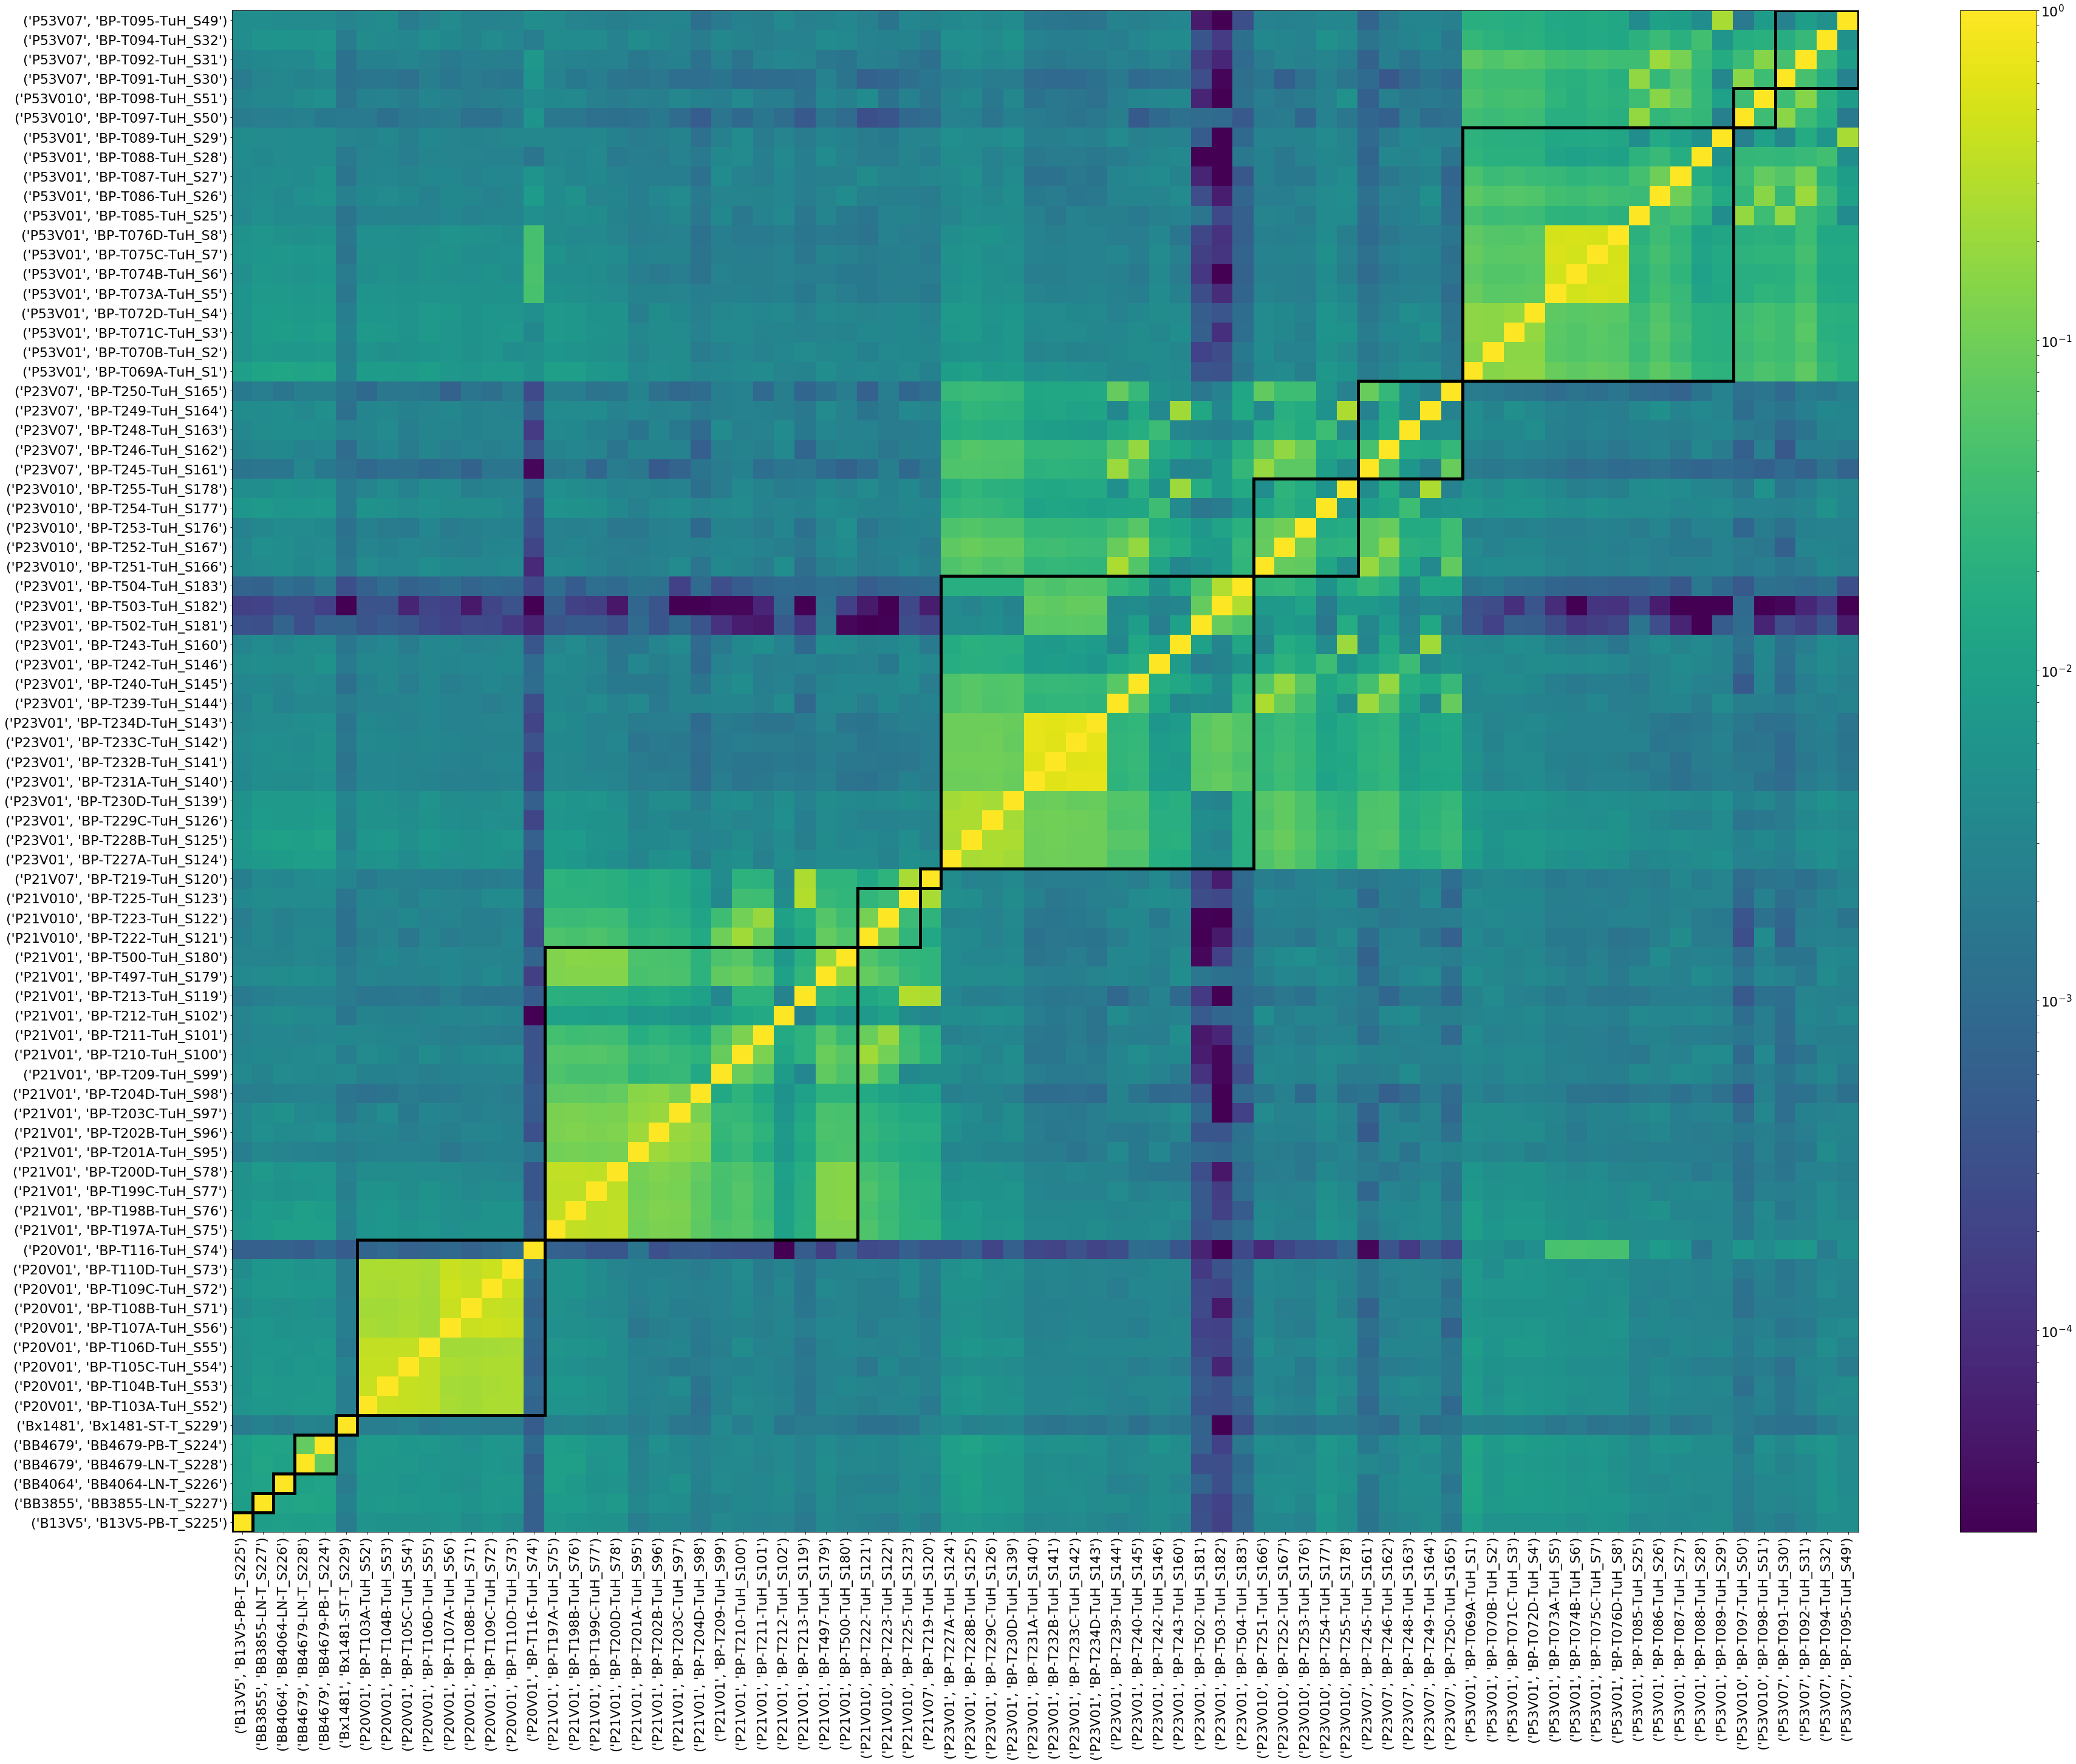

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.09509404221921042 0.1318815158375994
mean diff patient 0.007417148647292916 0.02107317893595949
threshold 0.09170986439113087


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb7dd9ed128>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb7dd9ed9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb7dd9f1f98>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb7dda28240>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7dda28668>,
 'means': []}

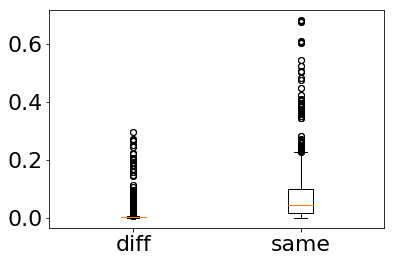

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

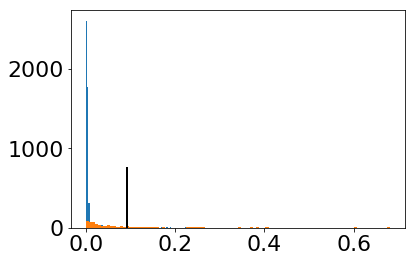

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('P21V01', 'BP-T209-TuH_S99') ('P21V010', 'BP-T222-TuH_S121') 0.0973160567226592
('P21V01', 'BP-T210-TuH_S100') ('P21V010', 'BP-T222-TuH_S121') 0.22366699150772662
('P21V01', 'BP-T210-TuH_S100') ('P21V010', 'BP-T223-TuH_S122') 0.10510073623418414
('P21V01', 'BP-T211-TuH_S101') ('P21V010', 'BP-T223-TuH_S122') 0.19191527184867108
('P21V01', 'BP-T213-TuH_S119') ('P21V010', 'BP-T225-TuH_S123') 0.2953664674911606
('P21V01', 'BP-T213-TuH_S119') ('P21V07', 'BP-T219-TuH_S120') 0.265681125177605
('P21V010', 'BP-T222-TuH_S121') ('P21V01', 'BP-T209-TuH_S99') 0.0973160567226592
('P21V010', 'BP-T222-TuH_S121') ('P21V01', 'BP-T210-TuH_S100') 0.22366699150772662
('P21V010', 'BP-T223-TuH_S122') ('P21V01', 'BP-T210-TuH_S100') 0.10510073623418414
('P21V010', 'BP-T223-TuH_S122') ('P21V01', 'BP-T211-TuH_S101') 0.19191527184867108
('P21V010', 'BP-T225-TuH_S123') ('P21V01', 'BP-T213-TuH_S119') 0.2953664674911606
('P21V010', 'BP-T225-TuH_S123') ('P21V07', 'BP-T219-TuH_S120') 0.24582841004063516
('P21V07', 'B

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 2.4483699976762807e-05
max value: 1.0
Wrote run41-similarity-TRB_HUMAN-highlighted.pdf to disk


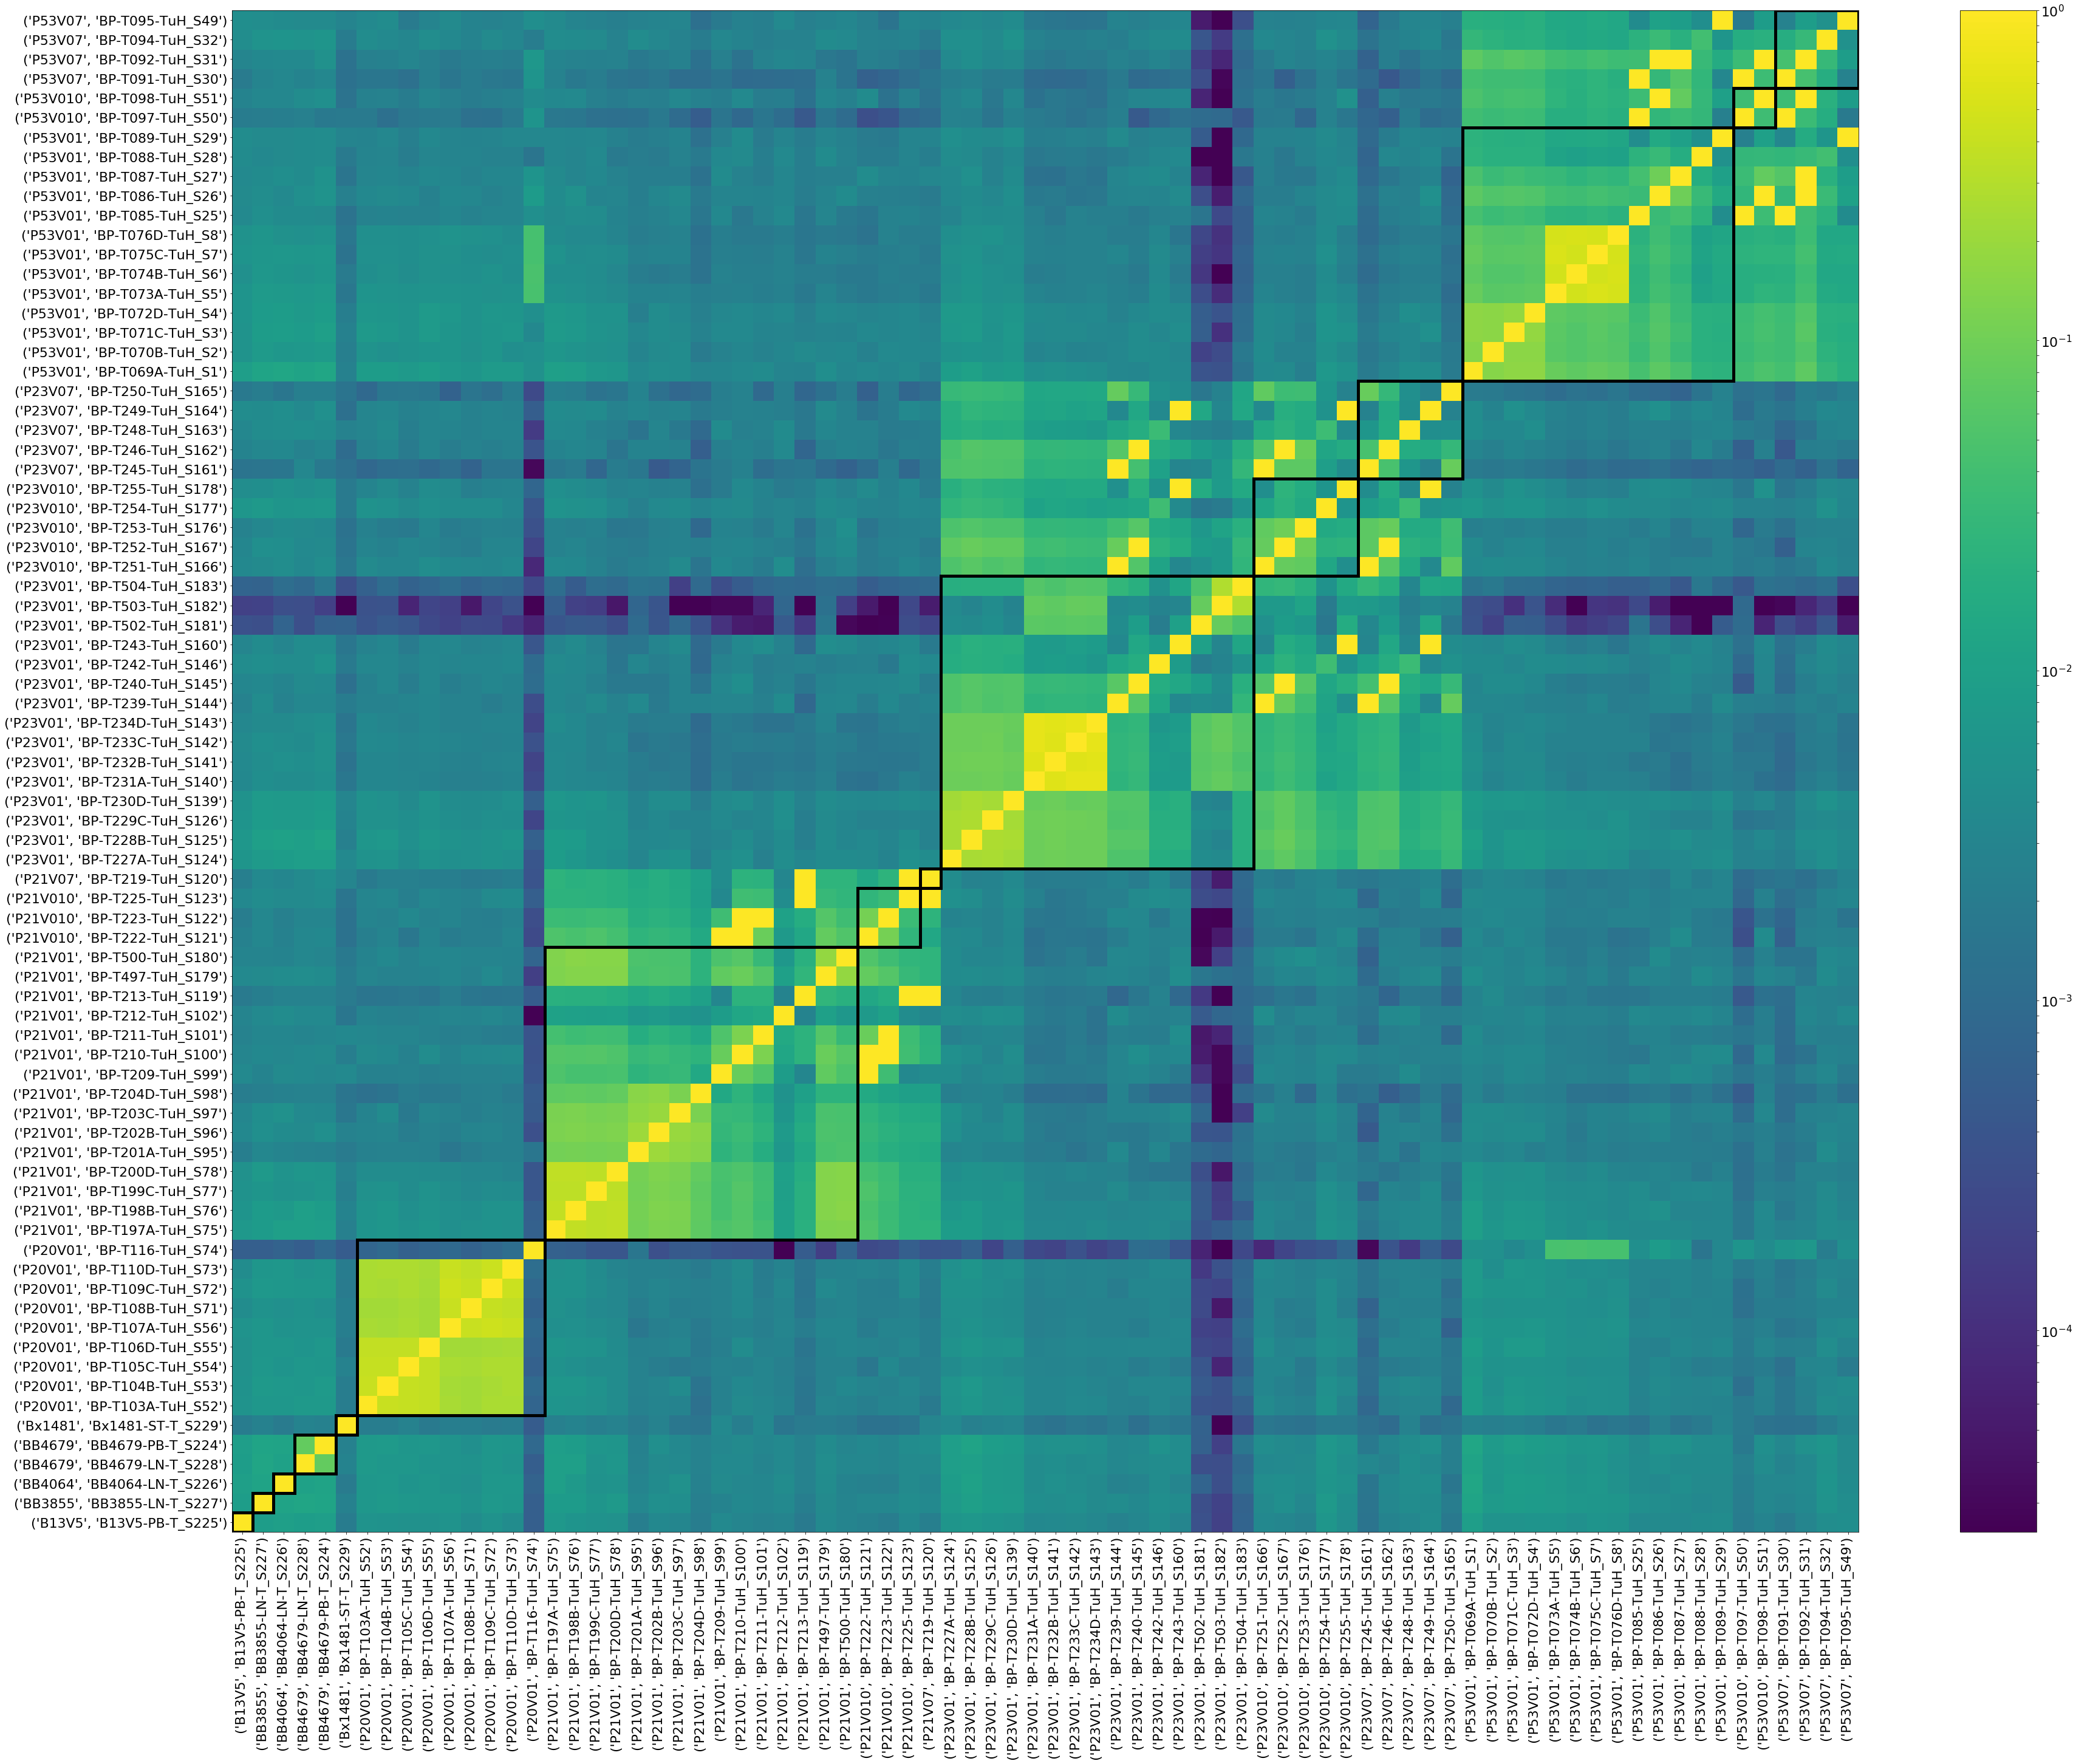

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)